In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, euclidean
import json
import os

In [10]:
# Sabitler
IMAGE_SIZE = 224
BATCH_SIZE = 32
EMBEDDING_DIM = 128
class_names = ['kedi', 'köpek']

In [60]:
def l2_normalize(x, axis=-1):
    """L2 normalizasyon - önemli: epsilon değeri çok düşük tutulmalı"""
    return tf.nn.l2_normalize(x, axis=axis, epsilon=1e-12)

def calculate_multiple_similarities(embedding1, embedding2):
    """
    Cosine ve Euclidean benzerlik hesaplama (negatif değer çıkmaz).
    """
    emb1 = embedding1.flatten()
    emb2 = embedding2.flatten()

    # Cosine similarity: 0 ~ 1
    cosine_dist = cosine(emb1, emb2)  # bu değer [0, 2] olabilir ama genelde [0,1]
    cosine_sim = max(0.0, 1 - cosine_dist)

    # Euclidean similarity: 0 ~ 1
    euclidean_dist = euclidean(emb1, emb2)
    euclidean_sim = 1 / (1 + euclidean_dist)  # her zaman 0 < x <= 1

    return {
        'cosine': cosine_sim,
        'euclidean': euclidean_sim
    }

def enhanced_similarity_scoring(similarities_dict):
    """
    Sadece pozitif değerli cosine ve euclidean metriklerini kullan.
    """
    weights = {
        'cosine': 0.6,
        'euclidean': 0.4
    }

    score = 0.0
    for metric, weight in weights.items():
        value = similarities_dict.get(metric, 0.0)
        # Negatif değer güvenliği (ama burada zaten negatif gelmez)
        value = max(0.0, min(value, 1.0))  # 0-1 aralığında tut
        score += weight * value

    return score

In [12]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "output/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "output/val",
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "output/test",
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# MobileNetV2 için ön işleme
def apply_preprocessing(dataset):
    preprocess_fn = applications.mobilenet_v2.preprocess_input
    return dataset.map(
        lambda x, y: (preprocess_fn(x), tf.cast(y, tf.float32)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).cache().prefetch(tf.data.AUTOTUNE)

# Veri akışını hazırla
train_dataset = apply_preprocessing(train_dataset)
val_dataset = apply_preprocessing(val_dataset)
test_dataset = apply_preprocessing(test_dataset)

Found 11949 files belonging to 2 classes.
Found 2487 files belonging to 2 classes.
Found 2486 files belonging to 2 classes.


In [13]:
def generate_triplets_from_directory(directory, batch_size=16, kedi_sample_ratio=3):
    generator = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=1,
        label_mode='int'
    )
    filenames = generator.file_paths
    labels = [lbls.numpy()[0] for _, lbls in generator]
    
    if not filenames or not labels:
        raise ValueError(f"Hata: {directory} dizininde veri bulunamadı.")
    print(f"{directory}: {len(filenames)} dosya bulundu.")
    
    def gen():
        while True:
            anchor_images = []
            positive_images = []
            negative_images = []
            
            for _ in range(batch_size):
                if np.random.rand() < kedi_sample_ratio / (kedi_sample_ratio + 1):
                    kedi_indices = [i for i, lbl in enumerate(labels) if lbl == 0]
                    if not kedi_indices:
                        continue
                    anchor_idx = np.random.choice(kedi_indices)
                else:
                    anchor_idx = np.random.randint(0, len(filenames))
                
                anchor_label = labels[anchor_idx]
                positive_indices = [i for i, lbl in enumerate(labels) if lbl == anchor_label]
                negative_indices = [i for i, lbl in enumerate(labels) if lbl != anchor_label]
                
                if not positive_indices or not negative_indices:
                    continue
                
                positive_idx = np.random.choice(positive_indices)
                negative_idx = np.random.choice(negative_indices)
                
                try:
                    anchor_img = tf.keras.preprocessing.image.load_img(filenames[anchor_idx], target_size=(IMAGE_SIZE, IMAGE_SIZE))
                    positive_img = tf.keras.preprocessing.image.load_img(filenames[positive_idx], target_size=(IMAGE_SIZE, IMAGE_SIZE))
                    negative_img = tf.keras.preprocessing.image.load_img(filenames[negative_idx], target_size=(IMAGE_SIZE, IMAGE_SIZE))
                except Exception as e:
                    print(f"Görüntü yükleme hatası: {e}")
                    continue
                
                anchor_img = tf.keras.preprocessing.image.img_to_array(anchor_img) / 255.0
                positive_img = tf.keras.preprocessing.image.img_to_array(positive_img) / 255.0
                negative_img = tf.keras.preprocessing.image.img_to_array(negative_img) / 255.0
                
                anchor_images.append(anchor_img)
                positive_images.append(positive_img)
                negative_images.append(negative_img)
            
            if len(anchor_images) == batch_size:
                yield (
                    (
                        np.array(anchor_images, dtype=np.float32),
                        np.array(positive_images, dtype=np.float32),
                        np.array(negative_images, dtype=np.float32)
                    ),
                    np.zeros((batch_size,), dtype=np.float32)
                )
    
    output_signature = (
        (
            tf.TensorSpec(shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )
    
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )


In [14]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

# F1 Score Metriği
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

# Eğitim ve test metrikleri grafiklerini çizme
def plot_metrics(history, model_name):
    metrics = [
        ('accuracy', f'{model_name} Eğitim ve Doğrulama Doğruluğu', 'Doğruluk'),
        ('loss', f'{model_name} Eğitim ve Doğrulama Kaybı', 'Kayıp'),
        ('precision', f'{model_name} Precision', 'Precision'),
        ('recall', f'{model_name} Recall', 'Recall'),
        ('f1_score', f'{model_name} F1 Score', 'F1 Score')
    ]
    
    for metric_name, title, ylabel in metrics:
        if metric_name in history.history:
            plt.figure(figsize=(8, 5))
            plt.plot(history.history[metric_name], label=f'Eğitim {metric_name}')
            plt.plot(history.history[f'val_{metric_name}'], label=f'Doğrulama {metric_name}')
            plt.title(title)
            plt.xlabel('Epoch')
            plt.ylabel(ylabel)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'{model_name.lower().replace(" ", "_")}_{metric_name}.png')
            plt.show()


In [15]:
def create_models():
    """Gelişmiş model mimarisi - L2 normalizasyon ve daha güçlü özellik çıkarma"""
    
    # MobileNetV2 base model
    base_model = applications.MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Base model katmanlarını dondur
    for layer in base_model.layers:
        layer.trainable = False
    
    # Son katmanları eğitilebilir yap
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Gelişmiş Feature Model
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Önceden eğitilmiş model özelliklerini al
    x = base_model(inputs, training=False)
    
    # Global pooling işlemleri - Daha zengin özellik çıkarma
    gap = layers.GlobalAveragePooling2D(name='gap')(x)
    gmp = layers.GlobalMaxPooling2D(name='gmp')(x)
    combined = layers.Concatenate(name='combined_features')([gap, gmp])
    
    # Daha güçlü özellik öğrenme
    x = layers.Dense(512, activation='relu', name='dense_1')(combined)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    
    x = layers.Dense(256, activation='relu', name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)
    
    # Embedding katmanı
    embedding = layers.Dense(EMBEDDING_DIM, activation='linear', name='embedding')(x)
    
    # L2 normalizasyon - ÇOK ÖNEMLİ!
    normalized_embedding = layers.Lambda(l2_normalize, name='l2_normalize')(embedding)
    
    feature_model = Model(inputs, normalized_embedding, name='feature_model')
    
    # Base Model (Sınıflandırma)
    classification_output = layers.Dense(1, activation='sigmoid', name='classification')(normalized_embedding)
    base_model = Model(inputs, classification_output, name='base_model')
    
    # Triplet Model
    input_anchor = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='anchor_input')
    input_positive = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='positive_input')
    input_negative = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='negative_input')
    
    embedding_anchor = feature_model(input_anchor)
    embedding_positive = feature_model(input_positive)
    embedding_negative = feature_model(input_negative)
    
    triplet_output = layers.Concatenate(name='triplet_output')([embedding_anchor, embedding_positive, embedding_negative])
    triplet_model = Model([input_anchor, input_positive, input_negative], triplet_output, name='triplet_model')
    
    return base_model, feature_model, triplet_model

In [16]:
# Ana eğitim fonksiyonu
def train_models():
    # Triplet veri setlerini hazırla
    triplet_dataset = generate_triplets_from_directory("output/train", BATCH_SIZE, kedi_sample_ratio=3)
    val_triplet_dataset = generate_triplets_from_directory("output/val", BATCH_SIZE, kedi_sample_ratio=3)
    
    # Modelleri oluştur
    base_model, feature_model, triplet_model = create_models()
    if base_model is None:
        return None, None, None, None, None
    
    # Sınıflandırma modelini derle ve eğit
    base_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), f1_score]
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    
    base_history = base_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,
        callbacks=[early_stopping, reduce_lr],
        class_weight={0: 2.5, 1: 0.6}
    )
    
    # Sınıflandırma sonuçlarını çiz
    plot_metrics(base_history, 'MobileNetV2_Classification')
    
    # Triplet modelini derle ve eğit
    triplet_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=triplet_loss
    )
    
    history = triplet_model.fit(
        triplet_dataset,
        validation_data=val_triplet_dataset,
        steps_per_epoch=11599 // BATCH_SIZE,
        validation_steps=2000 // BATCH_SIZE,
        epochs=5,
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Modelleri kaydet
    base_model.save('mobilenetv2_classification_model.keras')
    feature_model.save('mobilenetv2_feature_model.keras')
    
    return base_model, feature_model, triplet_model, base_history, history


In [ ]:
from tensorflow.keras.datasets import mnist
import mlflow
import mlflow.tensorflow
# MLflow otomatik TensorFlow entegrasyonu
mlflow.tensorflow.autolog()
triplet_dataset = generate_triplets_from_directory("output/train", BATCH_SIZE, kedi_sample_ratio=3)
val_triplet_dataset = generate_triplets_from_directory("output/val", BATCH_SIZE, kedi_sample_ratio=3)

with mlflow.start_run():
    # Modelleri oluştur
    base_model, feature_model, triplet_model = create_models()
    if base_model is None:
        return None, None, None, None, None
    
    # Sınıflandırma modelini derle ve eğit
    base_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), f1_score]
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    
    base_history = base_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,
        callbacks=[early_stopping, reduce_lr],
        class_weight={0: 2.5, 1: 0.6}
    )

In [18]:

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Özellik çıkarma fonksiyonu
def extract_features(image_path, model):
    img_array = preprocess_image(image_path)
    img_array = applications.mobilenet_v2.preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features[0]

In [49]:
def simple_cosine_similarity(embedding1, embedding2):
    """Sadece cosine similarity kullan - en güvenilir yöntem"""
    emb1 = embedding1.flatten()
    emb2 = embedding2.flatten()
    
    # Manuel cosine similarity hesabı
    dot_product = np.dot(emb1, emb2)
    norm_a = np.linalg.norm(emb1)
    norm_b = np.linalg.norm(emb2)
    
    if norm_a == 0 or norm_b == 0:
        return 0
    
    cosine_sim = dot_product / (norm_a * norm_b)
    return max(0, min(1, cosine_sim))  # 0-1 aralığında sınırla


In [77]:
def compute_and_visualize_similarity(
    classification_model_path='mobilenetv2_classification_model.keras',
    feature_model_path='mobilenetv2_feature_model.keras',
    test_image_path=r"C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.30 (2).jpeg",
    database_image_paths=[
        r"C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.29 (1).jpeg",
        r"C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.29.jpeg",
        r"C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.30 (7).jpeg",
        r"C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.30 (3).jpeg",
        r"C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.30 (4).jpeg",
        r"C:\Users\excalıbur\Downloads\WhatsApp Image 2025-07-07 at 14.23.50.jpeg"
    ]
):
    # TensorFlow oturumunu sıfırla
    tf.keras.backend.clear_session()
    
    # Modelleri yükle
    try:
        custom_objects = {
            'f1_score': f1_score,
            'l2_normalize': l2_normalize
        }
        
        classification_model = tf.keras.models.load_model(
            classification_model_path,
            custom_objects=custom_objects
        )
        feature_model = tf.keras.models.load_model(
            feature_model_path,
            custom_objects=custom_objects
        )
        print("Modeller başarıyla yüklendi.")
    except Exception as e:
        print(f"Model yükleme hatası: {e}")
        return
    
    # Eski embedding dosyasını sil
    if os.path.exists("database_embeddings.npy"):
        os.remove("database_embeddings.npy")
    if os.path.exists("database_image_paths.json"):
        os.remove("database_image_paths.json")
    
    # Veritabanı embedding'lerini hazırla
    database_embeddings = []
    valid_paths = []
    for path in database_image_paths:
        if os.path.exists(path):
            try:
                embedding = extract_features(path, feature_model)
                database_embeddings.append(embedding)
                valid_paths.append(path)
            except Exception as e:
                print(f"Embedding çıkarma hatası ({path}): {e}")
        else:
            print(f"Dosya bulunamadı: {path}")
    
    if len(database_embeddings) == 0:
        print("Geçerli veritabanı görseli bulunamadı!")
        return
    
    database_embeddings = np.array(database_embeddings)
    np.save("database_embeddings.npy", database_embeddings)
    with open("database_image_paths.json", "w") as f:
        json.dump(valid_paths, f)
    print("Veritabanı embedding'leri ve path'ler kaydedildi.")
    
    # Test görselini işle
    try:
        # Sınıflandırma tahmini
        test_image_batch = preprocess_image(test_image_path)
        test_image_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(test_image_batch)
        predictions = classification_model.predict(test_image_preprocessed, verbose=0)
        predicted_class = int(predictions[0].item() > 0.5)
        print(f"Test Görseli Tahmini: {class_names[predicted_class]}")
        
        # Test görselinin embedding'ini çıkar
        test_embedding = extract_features(test_image_path, feature_model)
        
        # Gelişmiş benzerlik hesaplama
        similarities = []
        similarity_threshold = 0.4  # Benzerlik eşiği
        
        for i, db_embedding in enumerate(database_embeddings):
            # Cosine ve Euclidean benzerlik metrikleri hesapla
            sim_metrics = calculate_multiple_similarities(test_embedding, db_embedding)
            
            # Gelişmiş skor hesapla
            enhanced_score = enhanced_similarity_scoring(sim_metrics)
            
            # Sadece eşik değerini geçen benzerlikler
            #if enhanced_score >= similarity_threshold:
            similarities.append((enhanced_score, i, sim_metrics))
        
        # Eğer hiç sonuç yoksa, eşiği düşür
        if len(similarities) == 0:
            print("Eşik çok yüksek, düşürülüyor...")
            similarity_threshold = 0.2
            for i, db_embedding in enumerate(database_embeddings):
                sim_metrics = calculate_multiple_similarities(test_embedding, db_embedding)
                enhanced_score = enhanced_similarity_scoring(sim_metrics)
                if enhanced_score >= similarity_threshold:
                    similarities.append((enhanced_score, i, sim_metrics))
        
        similarities.sort(reverse=True)
        top_3_matches = similarities[:min(3, len(similarities))]
        
        # Sonuçları görselleştirme
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Test görseli
        test_img = load_img(test_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        axes[0, 0].imshow(test_img)
        axes[0, 0].axis("off")
        axes[0, 0].set_title(f"Test Görseli\nTahmin: {class_names[predicted_class]}")
        
        # En benzer görseller
        for i, (similarity, idx, metrics) in enumerate(top_3_matches):
            try:
                img = load_img(valid_paths[idx], target_size=(IMAGE_SIZE, IMAGE_SIZE))
                row = (i + 1) // 2
                col = (i + 1) % 2
                axes[row, col].imshow(img)
                axes[row, col].axis("off")
                axes[row, col].set_title(f"Skor: {similarity:.3f}\nCos: {metrics['cosine']:.3f}\nEuc: {metrics['euclidean']:.3f}")
            except Exception as e:
                print(f"Görsel yükleme hatası ({valid_paths[idx]}): {e}")
        
        # Boş kalan eksenler varsa gizle
        for i in range(len(top_3_matches) + 1, 4):
            row = i // 2
            col = i % 2
            axes[row, col].axis("off")
        
        plt.tight_layout()
        plt.savefig("enhanced_similarity_results.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # Gelişmiş sonuçları yazdır ve kaydet
        print(f"\nTest Görseli ile En Benzer Görseller (Eşik: {similarity_threshold}):")
        with open("similarity_results.txt", "w", encoding='utf-8') as f:
            f.write(f"Test Görseli: {test_image_path}\n")
            f.write(f"Tahmin: {class_names[predicted_class]}\n")
            f.write(f"Benzerlik Eşiği: {similarity_threshold}\n\n")
            f.write("En Benzer Görseller:\n")
            for similarity, idx, metrics in top_3_matches:
                result = f"Görsel: {valid_paths[idx]}, Toplam Skor: {similarity:.4f}\n"
                result += f"  Cosine: {metrics['cosine']:.4f}, Euclidean: {metrics['euclidean']:.4f}\n"
                print(result.strip())
                f.write(result)
    
    except Exception as e:
        print(f"Test görseli işleme hatası: {e}")

Found 11949 files belonging to 2 classes.
output/train: 11949 dosya bulundu.
Found 2487 files belonging to 2 classes.
output/val: 2487 dosya bulundu.

Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 303s 756ms/step - accuracy: 0.9131 - f1_score: 0.9230 - loss: 0.5340 - precision: 0.9632 - recall: 0.8858 - val_accuracy: 0.9891 - val_f1_score: 0.6104 - val_loss: 0.1836 - val_precision: 0.9980 - val_recall: 0.9840 - learning_rate: 1.0000e-04
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 271s 724ms/step - accuracy: 0.9769 - f1_score: 0.9813 - loss: 0.2468 - precision: 0.9973 - recall: 0.9637 - val_accuracy: 0.9855 - val_f1_score: 0.6095 - val_loss: 0.1467 - val_precision: 0.9946 - val_recall: 0.9813 - learning_rate: 1.0000e-04
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 261s 698ms/step - accuracy: 0.9855 - f1_score: 0.9884 - loss: 0.1793 - precision: 0.9979 - recall: 0.9775 - val_accuracy: 0.9859 - val_f1_score: 0.6113 - val_loss: 0.1213 - val_precision: 0.9867 - val_recall: 0.9900 - learning_rate: 1.0000e-04


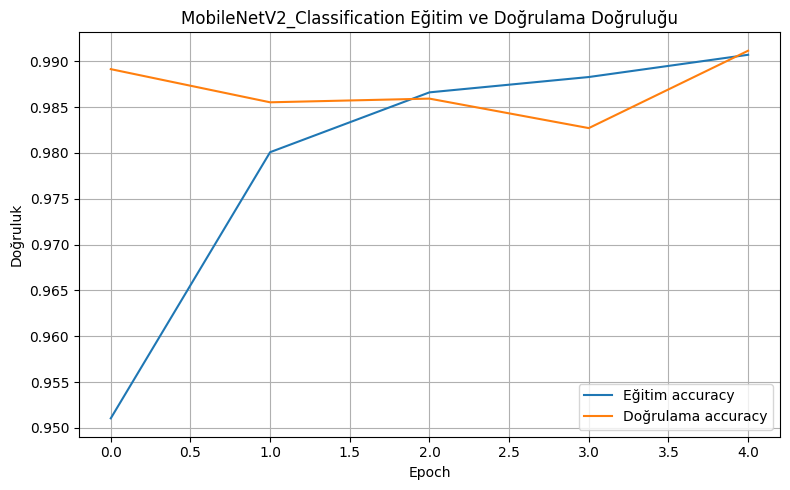

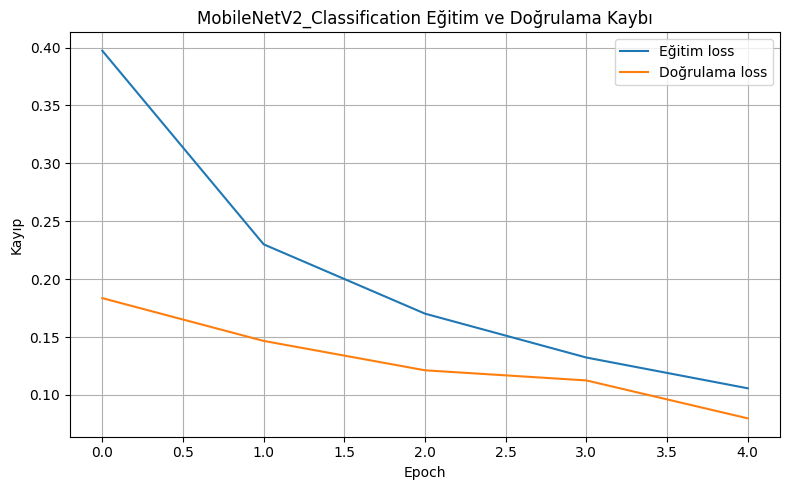

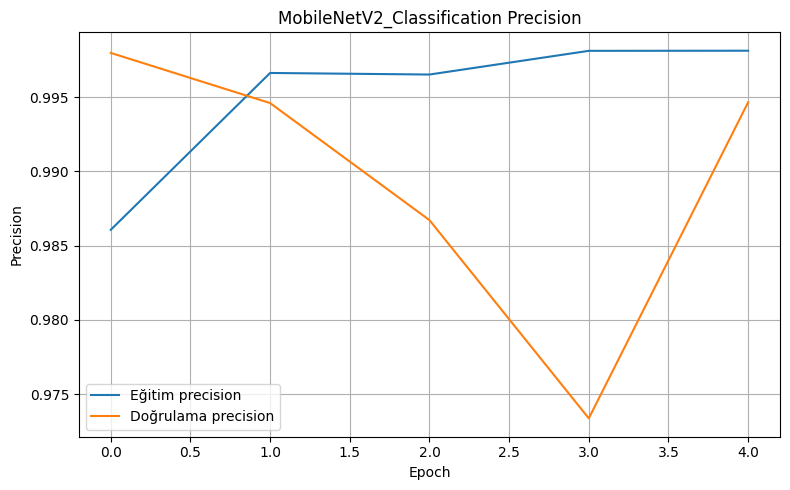

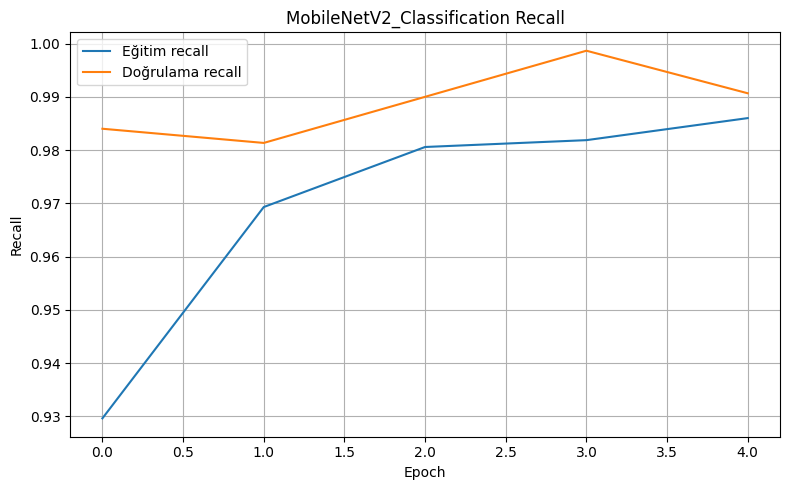

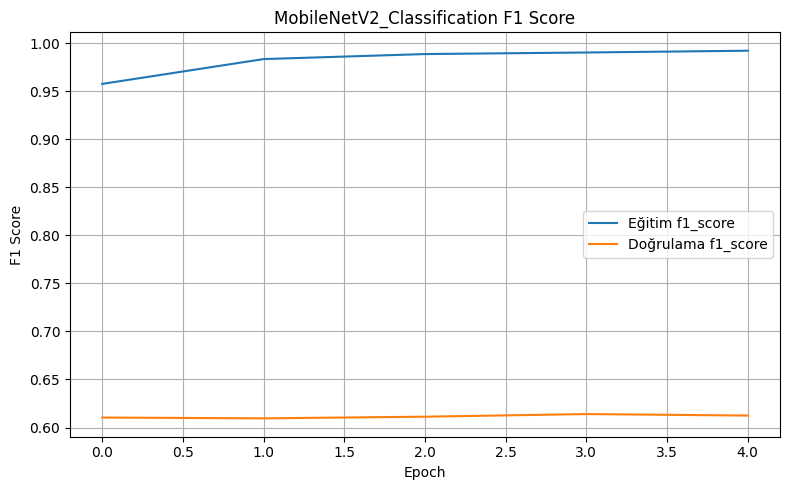

Epoch 1/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 903s 2s/step - loss: 0.9308 - val_loss: 0.4162 - learning_rate: 1.0000e-04
Epoch 2/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - loss: 0.2811 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 3/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - loss: 0.2628 - val_loss: 0.4169 - learning_rate: 1.0000e-04
Epoch 4/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - loss: 0.2606 - val_loss: 0.4033 - learning_rate: 1.0000e-04
Epoch 5/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - loss: 0.2620 - val_loss: 0.3937 - learning_rate: 1.0000e-04


In [20]:
base_model, feature_model, triplet_model, base_history, history = train_models()

Modeller başarıyla yüklendi.
Veritabanı embedding'leri ve path'ler kaydedildi.
Test Görseli Tahmini: kedi


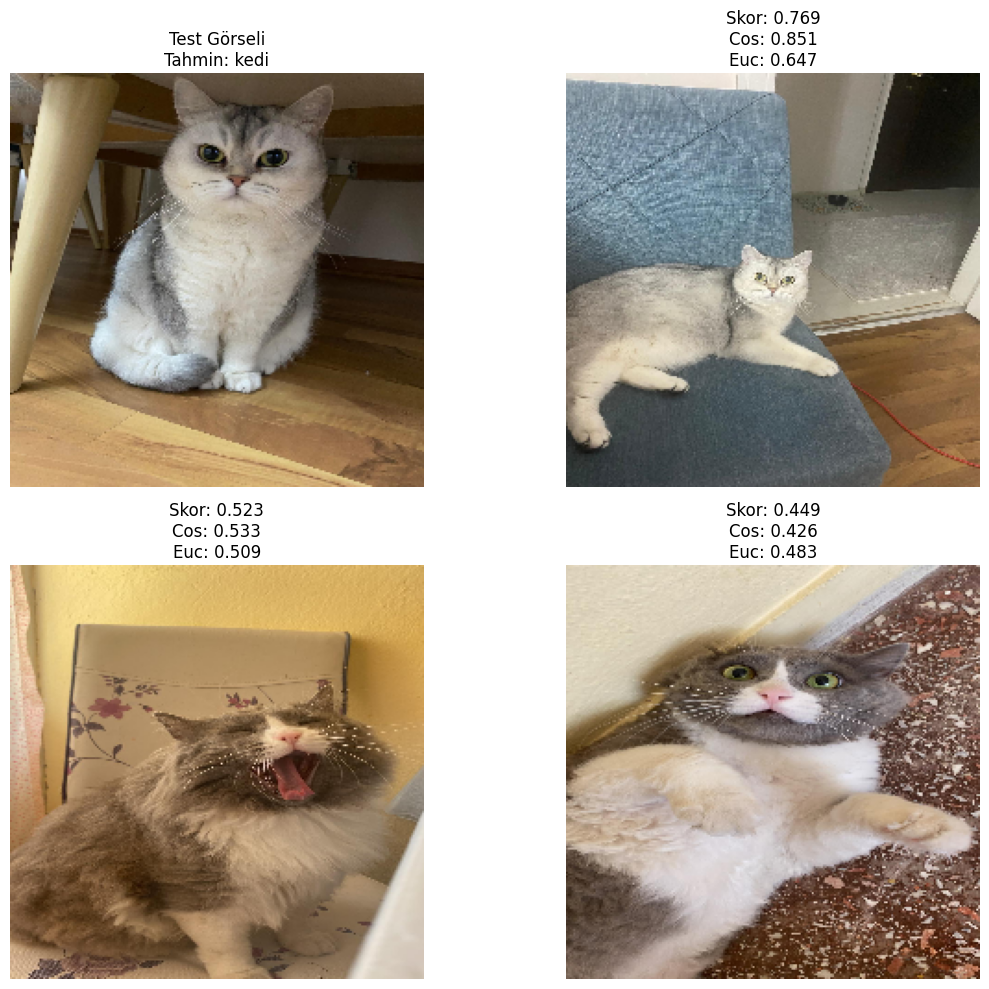


Test Görseli ile En Benzer Görseller (Eşik: 0.4):
Görsel: C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.30 (3).jpeg, Toplam Skor: 0.7693
  Cosine: 0.8510, Euclidean: 0.6469
Görsel: C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.29 (1).jpeg, Toplam Skor: 0.5235
  Cosine: 0.5333, Euclidean: 0.5086
Görsel: C:\Users\samet\evcil\WhatsApp Image 2025-05-04 at 19.14.29.jpeg, Toplam Skor: 0.4486
  Cosine: 0.4258, Euclidean: 0.4827


In [78]:
compute_and_visualize_similarity()

In [76]:
base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mobilenetv2_1.00_224          │ (None, 7, 7, 1280)        │       2,257,984 │ input_layer_1[0][0]        │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gap (GlobalAveragePooling2D)  │ (None, 1280)              │               0 │ mobilenetv2_1.00_224[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gmp (GlobalMaxPooling2D)      │ (None, 1280)              │               0 │ mobilenetv2_1.00_224[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ combined_features             │ (None, 2560)              │               0 │ gap[0][0], gmp[0][0]       │
│ (Concatenate)                 │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │       1,311,232 │ combined_features[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_1 (BatchNormalization)     │ (None, 512)               │           2,048 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 512)               │               0 │ bn_1[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 256)               │         131,328 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_2 (BatchNormalization)     │ (None, 256)               │           1,024 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 256)               │               0 │ bn_2[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Dense)             │ (None, 128)               │          32,896 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l2_normalize (Lambda)         │ (None, 128)               │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification (Dense)        │ (None, 1)                 │             129 │ l2_normalize[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,103,045 (34.73 MB)

 Trainable params: 2,683,201 (10.24 MB)

 Non-trainable params: 1,053,440 (4.02 MB)

 Optimizer params: 5,366,404 (20.47 MB)